In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd "/content/gdrive/MyDrive/Mask_RCNN"

/content/gdrive/MyDrive/Mask_RCNN


In [ ]:
!ls

assets	LICENSE      mask_rcnn_coco.h5	README.md	  samples   setup.cfg
images	MANIFEST.in  mrcnn		requirements.txt  save_img  setup.py


In [ ]:
# use tensorflow version 1.15.2
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.engine import saving
from tensorflow.python.keras.saving import hdf5_format
print(tf.__version__)

2.4.0


In [ ]:
print(keras.__version__)

2.4.0


In [ ]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../Mask_RCNN")

import warnings
warnings.filterwarnings("ignore")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/coco.py"))  # To find local version
import coco

%matplotlib inline

In [ ]:
ROOT_DIR

'/content/gdrive/MyDrive/Mask_RCNN'

In [ ]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join('', "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [ ]:
from mrcnn.config import Config
class CocoConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "coco"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Uncomment to train on 8 GPUs (default is 1)
    # GPU_COUNT = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 80  # COCO has 80 classes

In [ ]:
class InferenceConfig(CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_coco.hy', config=config)

# Load weights trained on MS-COCO
model.load_weights('mask_rcnn_coco.h5', by_name=True)

Instructions for updating:
Use fn_output_signature instead


In [ ]:
# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [ ]:
len(class_names)

81

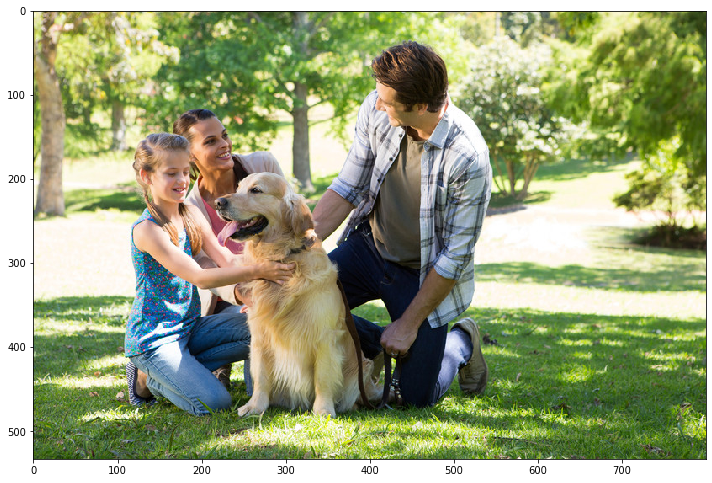

In [ ]:
# Load a random image from the images folder
image = skimage.io.imread('images/123.jpg')

# original image
plt.figure(figsize=(10,10))
skimage.io.imshow(image)

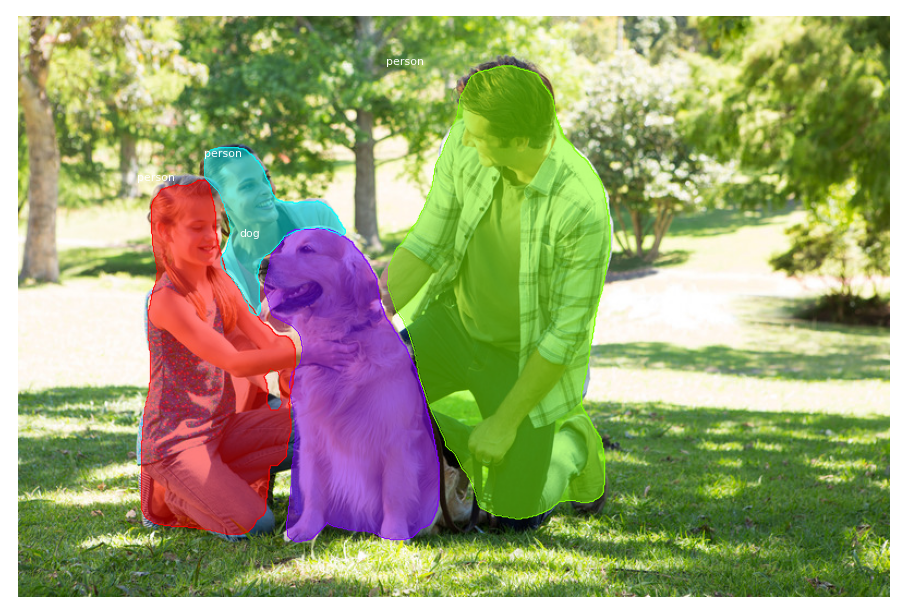

In [ ]:
# Run detection
results = model.detect([image])

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, show_bbox=False)

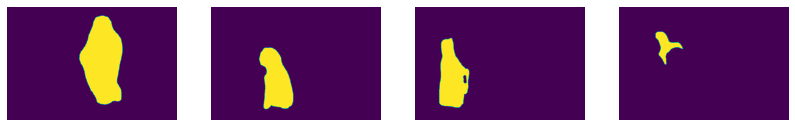

In [ ]:
from mrcnn.visualize import display_images
display_images(np.transpose(r['masks'], [2, 0, 1]))

In [ ]:
len(r['scores'])

4

In [ ]:
def extract(image, r):
      idx = r['scores'].argmax() + i
      mask = r['masks'][:,:,idx]
      mask = np.stack((mask,)*3, axis=-1)
      mask = mask.astype('uint8')
      bg = 255 - mask * 255
      mask_img = image*mask
      result = mask_img + bg
      return result

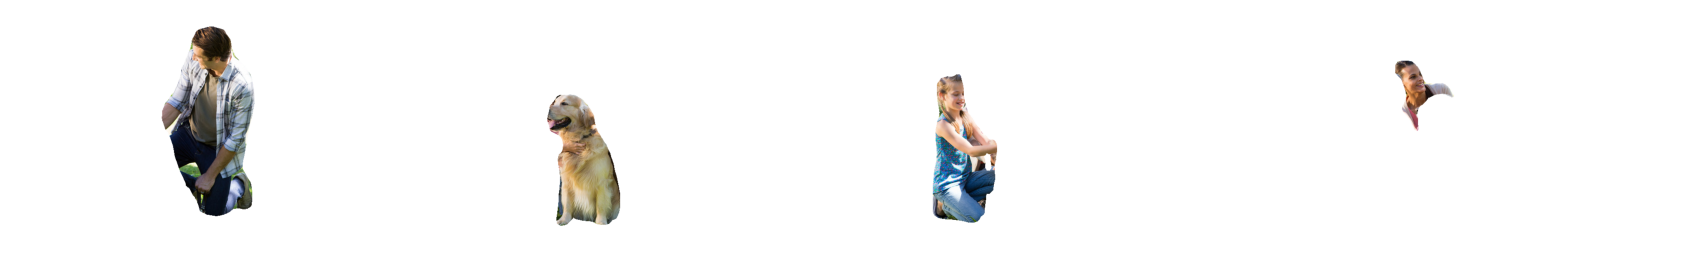

In [ ]:
fig = plt.figure(figsize=(30, 30))
columns = len(r['scores']) 
for i in range(0, columns*1):
    img = np.random.randint(10, size=(20,20))
    fig.add_subplot(1, columns, i + 1)
    plt.axis('off')
    plt.imshow(np.concatenate([extract(image, r)]))
    plt.savefig('save_img/1.png', dpi=500, bbox_inches='tight', transparent = True)
plt.show()

In [ ]:
!ls

assets	LICENSE      mask_rcnn_coco.h5	README.md	  samples   setup.cfg
images	MANIFEST.in  mrcnn		requirements.txt  save_img  setup.py


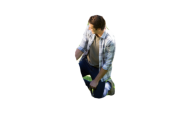

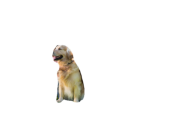

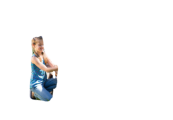

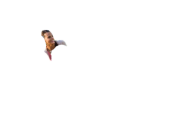

In [ ]:
for i in range(0, len(r['scores'])):
  cols = 6  
  rows = 3
  # rows = len(r['scores']) // cols + 1
  plt.figure(figsize=(20, 20))
  plt.subplot(rows, cols, 1)
  plt.axis('off')
  plt.imshow(np.concatenate([extract(image, r)], axis = 1))
  i += 1
  plt.show()

In [ ]:
pip install anvil-uplink

In [ ]:
import anvil.server

anvil.server.connect("FGKYXFASKAUC6Y4BF54EBVOS-WPE2YXHC7VABCEK2")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment (dev)" as SERVER


In [ ]:
def image_segmentation(file):
    image = skimage.io.imread(file)
    
    results = model.detect([image])
    r = results[0]
    # visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, show_bbox=False)

    def extract(image, r):
      idx = r['scores'].argmax() + i
      mask = r['masks'][:,:,idx]
      mask = np.stack((mask,)*3, axis=-1)
      mask = mask.astype('uint8')
      bg = 255 - mask * 255
      mask_img = image*mask
      result = mask_img + bg
      return result

    fig = plt.figure(figsize=(30, 30))
    columns = len(r['scores']) 
    for i in range(0, columns*1):
        img = np.random.randint(10, size=(20,20))
        fig.add_subplot(1, columns, i + 1)
        plt.axis('off')
        plt.imshow(np.concatenate([extract(image, r)]))
        plt.savefig('save_img/2.png', dpi=500, bbox_inches='tight', transparent = True)
    plt.show()
   
    # return visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, show_bbox=False)


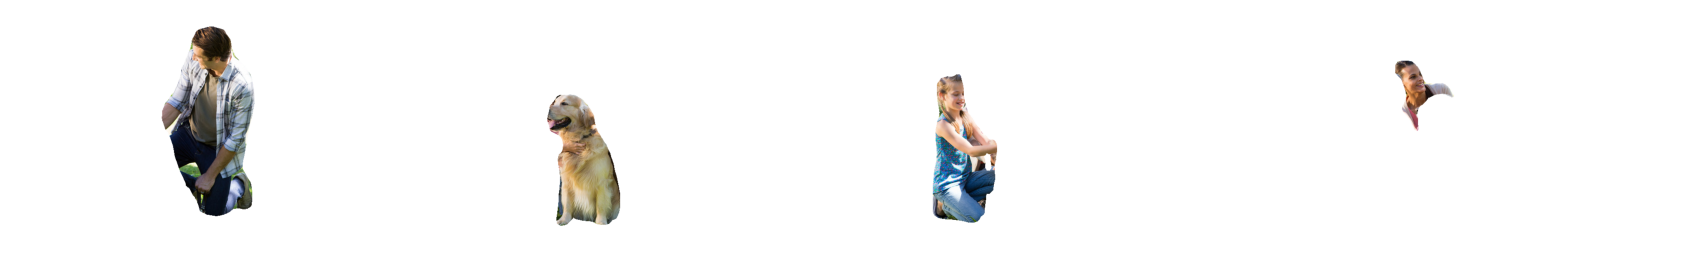

In [ ]:
image_segmentation('images/123.jpg')

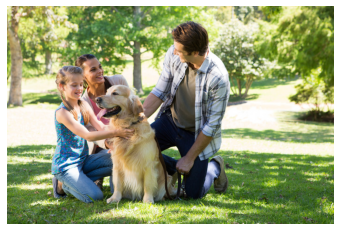

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img
image = load_img('images/123.jpg')
plt.axis('off')
plt.imshow(image)

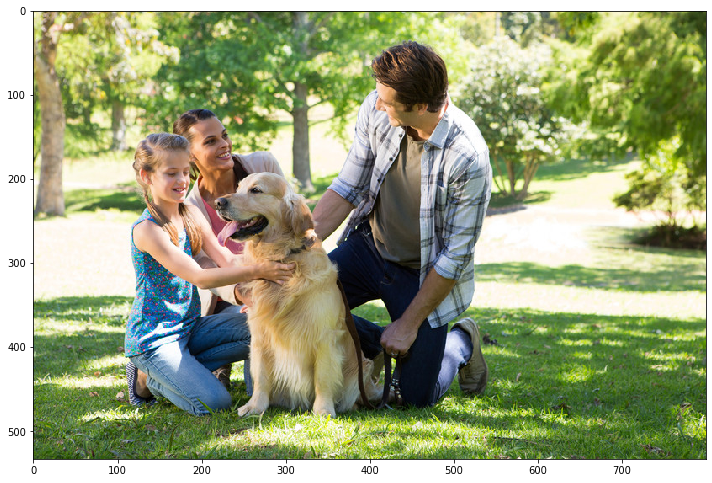

In [ ]:
image = skimage.io.imread('images/123.jpg')

# original image
plt.figure(figsize=(10,10))
skimage.io.imshow(image)

In [ ]:
# Test the function with Anvil
import anvil.media

@anvil.server.callable
def something(file):
  with anvil.media.TempFile(file) as filename:
    img = skimage.io.imread(filename)

    results = model.detect([img])
    r = results[0]
    score = len(r['scores'])

    return ('cat' if score < 3 else 'dog', float(score))


In [ ]:
something('images/123.jpg')